In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Load and preprocess MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 784) / 255.0
X_test = X_test.reshape(-1, 784) / 255.0

def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

y_train_oh = one_hot_encode(y_train)
y_test_oh = one_hot_encode(y_test)

# 2. Model architecture (784 → 128 → 64 → 10)
np.random.seed(42)

def init_weights():
    W1 = np.random.randn(784, 128) * np.sqrt(2. / 784)
    b1 = np.zeros((1, 128))
    W2 = np.random.randn(128, 64) * np.sqrt(2. / 128)
    b2 = np.zeros((1, 64))
    W3 = np.random.randn(64, 10) * np.sqrt(2. / 64)
    b3 = np.zeros((1, 10))
    return W1, b1, W2, b2, W3, b3

# Activation Functions
def relu(x): return np.maximum(0, x)
def relu_deriv(x): return (x > 0).astype(float)

def softmax(x):
    exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy(y_true, y_pred):
    eps = 1e-8
    return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))

def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

# 3. Forward pass
def forward(X, W1, b1, W2, b2, W3, b3):
    Z1 = X @ W1 + b1
    A1 = relu(Z1)
    Z2 = A1 @ W2 + b2
    A2 = relu(Z2)
    Z3 = A2 @ W3 + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

# 4. Backward pass
def backward(X, y, Z1, A1, Z2, A2, Z3, A3, W2, W3):
    m = y.shape[0]
    dZ3 = (A3 - y) / m
    dW3 = A2.T @ dZ3
    db3 = np.sum(dZ3, axis=0, keepdims=True)

    dA2 = dZ3 @ W3.T
    dZ2 = dA2 * relu_deriv(Z2)
    dW2 = A1.T @ dZ2
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * relu_deriv(Z1)
    dW1 = X.T @ dZ1
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3

# 5. Adam Optimizer
class AdamOptimizer:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [np.zeros_like(p) for p in params]
        self.v = [np.zeros_like(p) for p in params]
        self.t = 0

    def step(self, grads, params):
        self.t += 1
        updated_params = []
        for i, (g, p) in enumerate(zip(grads, params)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g ** 2)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            p -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
            updated_params.append(p)
        return updated_params

# 6. Training loop
W1, b1, W2, b2, W3, b3 = init_weights()
optimizer = AdamOptimizer([W1, b1, W2, b2, W3, b3])

batch_size = 32
epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(epochs):
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train_oh = y_train_oh[indices]

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train_oh[i:i+batch_size]

        Z1, A1, Z2, A2, Z3, A3 = forward(X_batch, W1, b1, W2, b2, W3, b3)
        loss = cross_entropy(y_batch, A3)

        grads = backward(X_batch, y_batch, Z1, A1, Z2, A2, Z3, A3, W2, W3)
        W1, b1, W2, b2, W3, b3 = optimizer.step(grads, [W1, b1, W2, b2, W3, b3])

    # Evaluate
    _, _, _, _, _, train_pred = forward(X_train, W1, b1, W2, b2, W3, b3)
    _, _, _, _, _, test_pred = forward(X_test, W1, b1, W2, b2, W3, b3)

    train_loss = cross_entropy(y_train_oh, train_pred)
    test_loss = cross_entropy(y_test_oh, test_pred)
    train_acc = accuracy(y_train_oh, train_pred)
    test_acc = accuracy(y_test_oh, test_pred)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# 7. Visualization
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.show()

plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

# Visualize predictions
for i in range(5):
    img = X_test[i].reshape(28, 28)
    label = np.argmax(y_test_oh[i])
    pred = np.argmax(test_pred[i])
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}, Predicted: {pred}")
    plt.axis('off')
    plt.show()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 15s 1us/step
Epoch 1/10 - Train Loss: 0.1081, Test Loss: 0.1242, Train Accuracy: 0.9677, Test Accuracy: 0.9619
Epoch 2/10 - Train Loss: 0.0844, Test Loss: 0.1126, Train Accuracy: 0.9735, Test Accuracy: 0.9650
Epoch 3/10 - Train Loss: 0.0598, Test Loss: 0.0966, Train Accuracy: 0.9811, Test Accuracy: 0.9700
Epoch 4/10 - Train Loss: 0.0392, Test Loss: 0.0832, Train Accuracy: 0.9877, Test Accuracy: 0.9740
Epoch 5/10 - Train Loss: 0.0286, Test Loss: 0.0913, Train Accuracy: 0.9908, Test Accuracy: 0.9746
Epoch 6/10 - Train Loss: 0.0281, Test Loss: 0.0810, Train Accuracy: 0.9911, Test Accuracy: 0.9779
Epoch 7/10 - Train Loss: 0.0242, Test Loss: 0.0906, Train Accuracy: 0.9922, Test Accuracy: 0.9751
Epoch 8/10 - Train Loss: 0.0208, Test Loss: 0.0866, Train Accuracy: 0.9933, Test Accuracy: 0.9775
Epoch 9/10 - Train Loss: 0.0177, Test Loss: 0.0952, Train Accuracy: 0.9944, Test Accuracy: 0.9758
Epoch 10/10 - Train Loss: 0.0101, Test Loss: 0.0904, Train Accurac

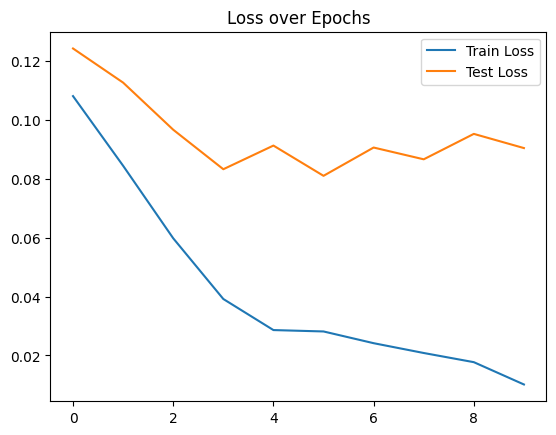

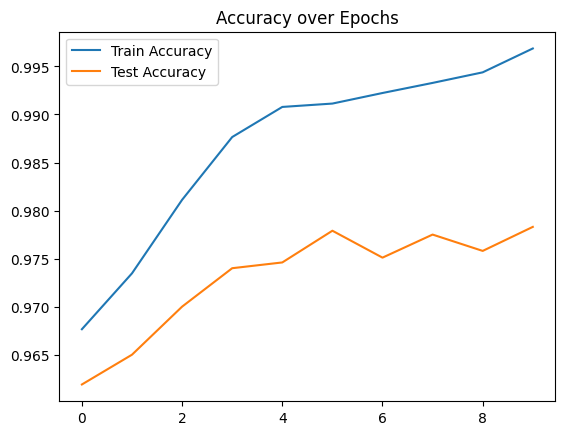

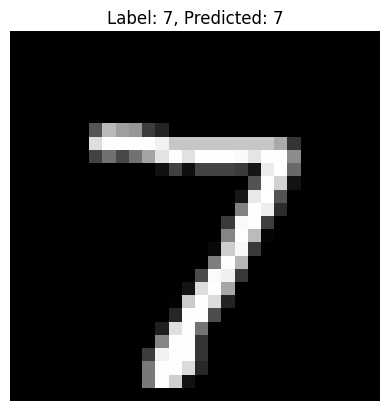

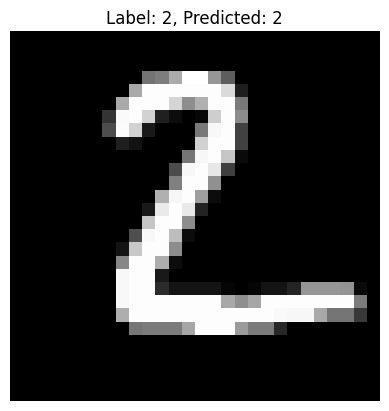

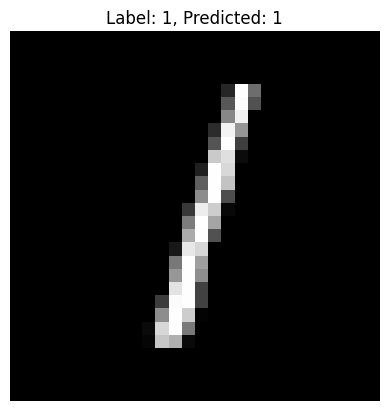

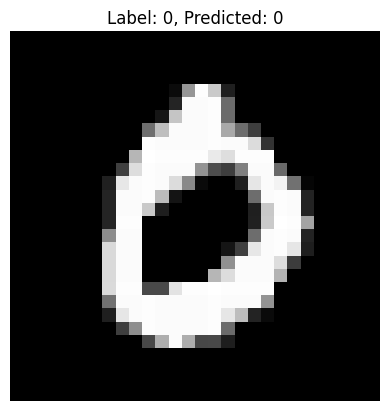

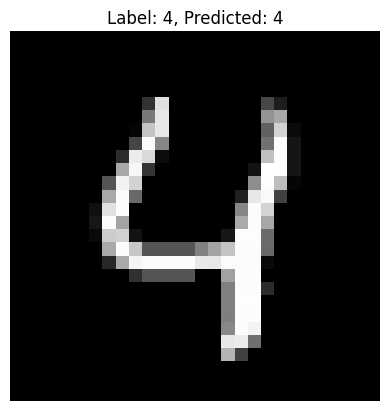

In [1]:
# Importing necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the MNIST dataset
def load_and_preprocess_data():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.reshape(-1, 784) / 255.0
    X_test = X_test.reshape(-1, 784) / 255.0
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_and_preprocess_data()

# Step 2: One-hot encode the labels
def one_hot_encode(labels, num_classes=10):
    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot

y_train_oh = one_hot_encode(y_train)
y_test_oh = one_hot_encode(y_test)

# Step 3: Initialize the weights for the neural network
def initialize_weights():
    np.random.seed(42)
    W1 = np.random.randn(784, 128) * np.sqrt(2. / 784)
    b1 = np.zeros((1, 128))
    W2 = np.random.randn(128, 64) * np.sqrt(2. / 128)
    b2 = np.zeros((1, 64))
    W3 = np.random.randn(64, 10) * np.sqrt(2. / 64)
    b3 = np.zeros((1, 10))
    return W1, b1, W2, b2, W3, b3

W1, b1, W2, b2, W3, b3 = initialize_weights()

# Step 4: Define activation functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)

# Step 5: Define loss and accuracy functions
def cross_entropy_loss(y_true, y_pred):
    eps = 1e-8
    return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))

def calculate_accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

# Step 6: Define the forward pass
def forward_pass(X, W1, b1, W2, b2, W3, b3):
    Z1 = X @ W1 + b1
    A1 = relu(Z1)
    Z2 = A1 @ W2 + b2
    A2 = relu(Z2)
    Z3 = A2 @ W3 + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

# Step 7: Define the backward pass
def backward_pass(X, y, Z1, A1, Z2, A2, Z3, A3, W2, W3):
    m = y.shape[0]
    dZ3 = (A3 - y) / m
    dW3 = A2.T @ dZ3
    db3 = np.sum(dZ3, axis=0, keepdims=True)

    dA2 = dZ3 @ W3.T
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = A1.T @ dZ2
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = X.T @ dZ1
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3

# Step 8: Define the Adam Optimizer
class AdamOptimizer:
    def __init__(self, params, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [np.zeros_like(p) for p in params]
        self.v = [np.zeros_like(p) for p in params]
        self.t = 0

    def update_params(self, grads, params):
        self.t += 1
        updated_params = []
        for i, (g, p) in enumerate(zip(grads, params)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g ** 2)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            p -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            updated_params.append(p)
        return updated_params

# Step 9: Training loop
optimizer = AdamOptimizer([W1, b1, W2, b2, W3, b3])

batch_size = 32
epochs = 10
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train_oh = y_train_oh[indices]

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train_oh[i:i+batch_size]

        Z1, A1, Z2, A2, Z3, A3 = forward_pass(X_batch, W1, b1, W2, b2, W3, b3)
        loss = cross_entropy_loss(y_batch, A3)

        grads = backward_pass(X_batch, y_batch, Z1, A1, Z2, A2, Z3, A3, W2, W3)
        W1, b1, W2, b2, W3, b3 = optimizer.update_params(grads, [W1, b1, W2, b2, W3, b3])

    # Evaluate
    _, _, _, _, _, train_pred = forward_pass(X_train, W1, b1, W2, b2, W3, b3)
    _, _, _, _, _, test_pred = forward_pass(X_test, W1, b1, W2, b2, W3, b3)

    train_loss = cross_entropy_loss(y_train_oh, train_pred)
    test_loss = cross_entropy_loss(y_test_oh, test_pred)
    train_accuracy = calculate_accuracy(y_train_oh, train_pred)
    test_accuracy = calculate_accuracy(y_test_oh, test_pred)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Step 10: Visualization
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

# Visualize predictions
for i in range(5):
    img = X_test[i].reshape(28, 28)
    label = np.argmax(y_test_oh[i])
    pred = np.argmax(test_pred[i])
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}, Predicted: {pred}")
    plt.axis('off')
    plt.show()
